# Required Imports


In [105]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from collections import defaultdict
from itertools import combinations
from sklearn.naive_bayes import MultinomialNB

# Data Processing


In [106]:
df = pd.read_csv("adult.csv")

print("Columns in your dataset:")
print(df.columns, "\n")

categorical_features = [
    "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "sex", "native-country"
]

target_col = "income"

df = df[categorical_features + [target_col]]

df = df.replace("?", "Unknown")

label_encoders = {}

for col in categorical_features + [target_col]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


train, temp = train_test_split(
    df, test_size=0.30, random_state=42, stratify=df[target_col])
val, test = train_test_split(
    temp, test_size=0.50, random_state=42, stratify=temp[target_col])

print("Dataset Split Sizes:")
print(f" Train: {len(train)} rows")
print(f" Validation: {len(val)} rows")
print(f" Test: {len(test)} rows\n")

print("Income Class Distribution (%):")
print(df[target_col].value_counts(normalize=True) * 100, "\n")

print("Feature-Target Relationship (mean indicates probability of >50k):")
for col in categorical_features:
    print(f"\n--- {col} ---")
    print(df.groupby(col)[target_col].mean().sort_values(ascending=False))

Columns in your dataset:
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object') 

Dataset Split Sizes:
 Train: 22792 rows
 Validation: 4884 rows
 Test: 4885 rows

Income Class Distribution (%):
income
0    75.919044
1    24.080956
Name: proportion, dtype: float64 

Feature-Target Relationship (mean indicates probability of >50k):

--- workclass ---
workclass
5    0.557348
1    0.386458
2    0.294792
6    0.284927
7    0.271957
4    0.218673
0    0.104031
3    0.000000
8    0.000000
Name: income, dtype: float64

--- education ---
education
10    0.740920
14    0.734375
12    0.556587
9     0.414753
8     0.261216
7     0.248360
15    0.190235
11    0.159509
2     0.076212
0     0.066452
5     0.061920
6     0.052529
1     0.051064
4     0.048048
3     0.035714
13    0.000000
Name: income, dtyp

In [107]:
# import pandas as pd
# import numpy as np


# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column_names = [
#     "age","workclass","fnlwgt","education","education-num",
#     "marital-status","occupation","relationship","race",
#     "sex","capital-gain","capital-loss","hours-per-week",
#     "native-country","income"
# ]

# df = pd.read_csv(url, names=column_names, header=None)
# df.to_csv("adult.csv", index=False)     # save locally if you want
# print(df.head())

# target_col = "income"

# df = df[column_names + [target_col]].copy()

# df.replace("?", "Unknown", inplace=True)

# feature_maps = {}
# for col in column_names:
#     unique_vals = sorted(df[col].unique())
#     mapping = {v:i for i,v in enumerate(unique_vals)}
#     feature_maps[col] = mapping
#     df[col] = df[col].map(mapping)

# target_map = {"<=50K":0, ">50K":1}
# df[target_col] = df[target_col].map(target_map)


# train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df[target_col], random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df[target_col], random_state=42)

# print("Train size:", len(train_df))
# print("Validation size:", len(val_df))
# print("Test size:", len(test_df))

# print("\nClass distribution:")
# print(df[target_col].value_counts(normalize=True))

# for col in column_names:
#     print(f"\n{col} vs income:")
#     print(pd.crosstab(df[col], df[target_col], normalize="index").round(2).head())

# Model Implementation


In [108]:
class CategoricalNaiveBayes:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_likelihoods = {}
        self.classes = None
        self.feature_values = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = len(y)
        n_classes = len(self.classes)

        # Compute class priors
        for c in self.classes:
            self.class_priors[c] = (
                np.sum(y == c) + self.alpha) / (n_samples + self.alpha * n_classes)

        self.feature_likelihoods = {col: {} for col in X.columns}
        for col in X.columns:
            self.feature_values[col] = X[col].nunique()
            for val in X[col].unique():
                self.feature_likelihoods[col][val] = {}
                for c in self.classes:
                    count = np.sum((X[col] == val) & (y == c))
                    total_c = np.sum(y == c)
                    self.feature_likelihoods[col][val][c] = (
                        count + self.alpha
                    ) / (total_c + self.alpha * self.feature_values[col])

    def predict_single(self, x):
        probs = {}
        for c in self.classes:
            prob = self.class_priors[c]
            for col in x.index:
                val = x[col]
                prob *= self.feature_likelihoods[col].get(val, {}).get(
                    c, self.alpha / (self.alpha * self.feature_values[col]))
            probs[c] = prob
        # Return class with max probability
        return max(probs, key=probs.get)

    def predict(self, X):
        return X.apply(self.predict_single, axis=1)

# Model Usage

using different alpha values


In [109]:
X_train = train[categorical_features]
y_train = train[target_col]
X_val = val[categorical_features]
y_val = val[target_col]

alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
results = {}

for alpha in alphas:
    nb = CategoricalNaiveBayes(alpha=alpha)
    nb.fit(X_train, y_train)
    y_val_pred = nb.predict(X_val)
    acc = np.mean(y_val_pred == y_val)
    results[alpha] = acc
    print(f"Alpha = {alpha}: Validation Accuracy = {acc*100:.2f}%")

Alpha = 0.1: Validation Accuracy = 79.63%
Alpha = 0.5: Validation Accuracy = 79.65%
Alpha = 1.0: Validation Accuracy = 79.63%
Alpha = 2.0: Validation Accuracy = 79.65%
Alpha = 5.0: Validation Accuracy = 79.44%


applying feature selection


In [110]:

feature_subsets = list(combinations(categorical_features, 3))

subset_results = {}
for subset in feature_subsets[:5]:
    X_train_sub = X_train[list(subset)]
    X_val_sub = X_val[list(subset)]

    nb = CategoricalNaiveBayes(alpha=1)
    nb.fit(X_train_sub, y_train)
    y_val_pred = nb.predict(X_val_sub)
    acc = np.mean(y_val_pred == y_val)
    subset_results[subset] = acc
    print(f"Features {subset}: Validation Accuracy = {acc*100:.2f}%")

Features ('workclass', 'education', 'marital-status'): Validation Accuracy = 82.08%
Features ('workclass', 'education', 'occupation'): Validation Accuracy = 77.29%
Features ('workclass', 'education', 'relationship'): Validation Accuracy = 82.08%
Features ('workclass', 'education', 'race'): Validation Accuracy = 77.46%
Features ('workclass', 'education', 'sex'): Validation Accuracy = 78.40%


applying probability analysis


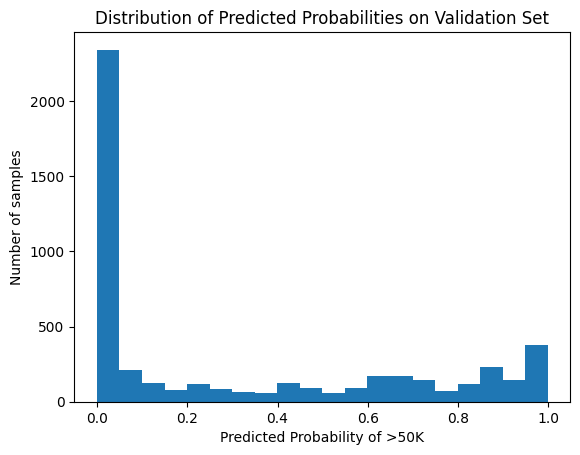

In [111]:
def predict_proba(nb_model, X):
    probs = []
    for _, row in X.iterrows():
        prob_class1 = nb_model.class_priors[1]
        for col in X.columns:
            val = row[col]
            prob_class1 *= nb_model.feature_likelihoods[col].get(val, {}).get(1, 1e-6)
        probs.append(prob_class1)
    probs = np.array(probs)
    return probs / (probs + np.array([nb_model.class_priors[0] *
        np.prod([nb_model.feature_likelihoods[col].get(row[col], {}).get(0, 1e-6) for col in X.columns])
        for _, row in X.iterrows()]))  

nb_model = CategoricalNaiveBayes(alpha=1)
nb_model.fit(X_train, y_train)

probs_val = predict_proba(nb_model, X_val)
import matplotlib.pyplot as plt

plt.hist(probs_val, bins=20)
plt.xlabel("Predicted Probability of >50K")
plt.ylabel("Number of samples")
plt.title("Distribution of Predicted Probabilities on Validation Set")
plt.show()


independent features assumption

                workclass  education  marital-status  occupation  \
workclass        1.000000   0.022731       -0.063615    0.252144   
education        0.022731   1.000000       -0.036956   -0.027865   
marital-status  -0.063615  -0.036956        1.000000   -0.009410   
occupation       0.252144  -0.027865       -0.009410    1.000000   
relationship    -0.088865  -0.010095        0.186924   -0.072865   
race             0.055115   0.016281       -0.063342    0.007336   
sex              0.094338  -0.026579       -0.133941    0.078216   
native-country  -0.007398   0.067533       -0.027770   -0.008273   

                relationship      race       sex  native-country  
workclass          -0.088865  0.055115  0.094338       -0.007398  
education          -0.010095  0.016281 -0.026579        0.067533  
marital-status      0.186924 -0.063342 -0.133941       -0.027770  
occupation         -0.072865  0.007336  0.078216       -0.008273  
relationship        1.000000 -0.122455 -0.578564    

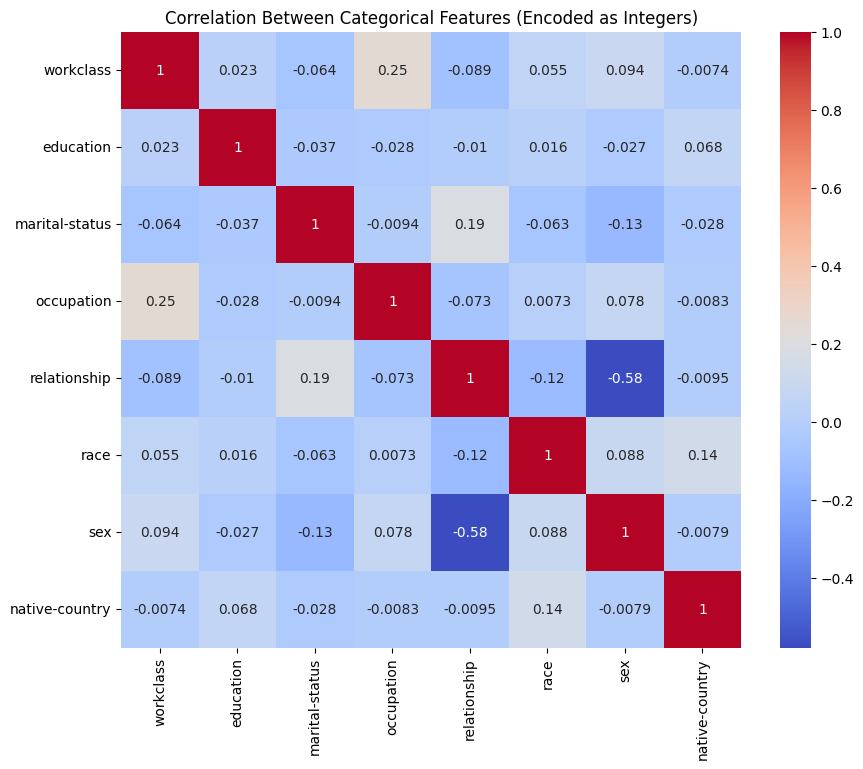

In [112]:
encoded = X_train.apply(lambda col: col.astype('category').cat.codes)
corr_matrix = encoded.corr()
print(corr_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Between Categorical Features (Encoded as Integers)")
plt.show()


comparing with sklearn

In [113]:
X_train_skl = X_train.copy()
X_val_skl = X_val.copy()

mnb = MultinomialNB(alpha=1.0)
mnb.fit(X_train_skl, y_train)
y_val_pred_skl = mnb.predict(X_val_skl)

accuracy_skl = np.mean(y_val_pred_skl == y_val)
print(f"Sklearn MultinomialNB Validation Accuracy: {accuracy_skl*100:.2f}%")

Sklearn MultinomialNB Validation Accuracy: 74.67%
